# Blast Furnace Optimization With PCI and O2 Injection

Code written by Ahmad Ishamul Ayady Akmal of USTB for the Ironmaking Course

Contact: m202461117@xs.ustb.edu.cn

Updated on Jan. 01,2025

### **Import and Data Preparation**



In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize, differential_evolution
from scipy.interpolate import griddata

# Setting the plot style
sns.set(style="whitegrid")


In [2]:
# First Data: PCI Variant with constant O2
data1 = {
    'PCI_Injection_kg_t': list(range(0, 260, 10)),  # 0 to 250 inclusive → 26 values
    'O2_injection_kg_t': [32.60]*26,               # 26 values
    'C_in_coke_charge': [433, 424, 416, 407, 398, 390, 381, 373, 364, 356, 347, 339, 330, 321, 313, 304, 296, 287, 279, 270, 262, 253, 244, 236, 227, 219],
    'Flame_temperature_C': [2343, 2325, 2308, 2291, 2275, 2258, 2242, 2225, 2209, 2194, 2178, 2162, 2147, 2132, 2117, 2102, 2088, 2073, 2059, 2045, 2031, 2017, 2003, 1989, 1976, 1963],
    'Top_gas_temperature_C': [12, 20, 28, 36, 44, 52, 60, 68, 76, 83, 91, 99, 107, 114, 122, 129, 137, 144, 152, 159, 166, 174, 181, 188, 196, 203]
}

# Second Data: O2 Variant with constant PCI
data2 = {
    'PCI_Injection_kg_t': [150]*12,
    'O2_injection_kg_t': [0.00, 5.00, 10.00, 15.00, 20.00, 25.00, 30.00, 32.60, 35.00, 40.00, 45.00, 50.00],
    'C_in_coke_charge': [303, 303, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305],
    'Flame_temperature_C': [2047, 2055, 2063, 2072, 2080, 2089, 2098, 2102, 2107, 2116, 2125, 2134],
    'Top_gas_temperature_C': [162, 157, 152, 147, 142, 137, 132, 129, 127, 121, 116, 111]
}


In [3]:
# Creating a DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Merging both datasets
df = pd.concat([df1, df2], ignore_index=True)

# Showing the first few lines
print("The first few rows of the merged dataset:")
print(df.head())
print("\nNumber of rows in the merged dataset:", len(df))


The first few rows of the merged dataset:
   PCI_Injection_kg_t  O2_injection_kg_t  C_in_coke_charge  \
0                   0               32.6               433   
1                  10               32.6               424   
2                  20               32.6               416   
3                  30               32.6               407   
4                  40               32.6               398   

   Flame_temperature_C  Top_gas_temperature_C  
0                 2343                     12  
1                 2325                     20  
2                 2308                     28  
3                 2291                     36  
4                 2275                     44  

Number of rows in the merged dataset: 38


In [4]:
# Check the length of each column in data1
print("\nLength of each column in data1:")
for key, value in data1.items():
    print(f"{key}: {len(value)}")

# Check the length of each column in data2
print("\nLength of each column in data2:")
for key, value in data2.items():
    print(f"{key}: {len(value)}")



Length of each column in data1:
PCI_Injection_kg_t: 26
O2_injection_kg_t: 26
C_in_coke_charge: 26
Flame_temperature_C: 26
Top_gas_temperature_C: 26

Length of each column in data2:
PCI_Injection_kg_t: 12
O2_injection_kg_t: 12
C_in_coke_charge: 12
Flame_temperature_C: 12
Top_gas_temperature_C: 12


### **Data Interpolation**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata

# Define ranges for PCI and O2
PCI_range = np.arange(0, 251, 5)  # 0 up to 250 with intervals of 5
O2_range = np.arange(0, 51, 1)     # 0 to 50 with intervals of 1

# Create a combination grid of PCI and O2
PCI_grid, O2_grid = np.meshgrid(PCI_range, O2_range)
PCI_grid_flat = PCI_grid.flatten()
O2_grid_flat = O2_grid.flatten()

# Create a new combination DataFrame
new_combinations = pd.DataFrame({
    'PCI_Injection_kg_t': PCI_grid_flat,
    'O2_injection_kg_t': O2_grid_flat
})

print("Some new PCI and O2 combinations:")
print(new_combinations.head())
print("\nNumber of new combinations:", len(new_combinations))


Some new PCI and O2 combinations:
   PCI_Injection_kg_t  O2_injection_kg_t
0                   0                  0
1                   5                  0
2                  10                  0
3                  15                  0
4                  20                  0

Number of new combinations: 2601


In [6]:
# Determine the desired number of samples
num_samples = 100  # For example, 100 samples

# Generate random combinations
np.random.seed(42)  # For reproducibility
random_PCI = np.random.uniform(0, 250, num_samples)
random_O2 = np.random.uniform(0, 50, num_samples)

# Create a random combination DataFrame
random_combinations = pd.DataFrame({
    'PCI_Injection_kg_t': random_PCI,
    'O2_injection_kg_t': random_O2
})

print("Some random PCI and O2 combinations:")
print(random_combinations.head())
print("\nNumber of random combinations:", len(random_combinations))


Some random PCI and O2 combinations:
   PCI_Injection_kg_t  O2_injection_kg_t
0           93.635030           1.571459
1          237.678577          31.820521
2          182.998485          15.717799
3          149.664621          25.428535
4           39.004660          45.378324

Number of random combinations: 100


In [7]:
from scipy.interpolate import griddata

# Combine data1 and data2 for interpolation
df_combined = pd.concat([df1, df2], ignore_index=True)

# Function to perform interpolation
def interpolate_target(df, new_df, target):
    points = df[['PCI_Injection_kg_t', 'O2_injection_kg_t']].values
    values = df[target].values
    new_values = griddata(points, values, new_df[['PCI_Injection_kg_t', 'O2_injection_kg_t']].values, method='linear')
    return new_values

# Interpolation example for C_in_coke_charge
new_combinations['C_in_coke_charge'] = interpolate_target(df_combined, new_combinations, 'C_in_coke_charge')
new_combinations['Flame_temperature_C'] = interpolate_target(df_combined, new_combinations, 'Flame_temperature_C')
new_combinations['Top_gas_temperature_C'] = interpolate_target(df_combined, new_combinations, 'Top_gas_temperature_C')

# Deleting rows with NaN values ​​from interpolation
new_combinations.dropna(inplace=True)

print("\nNew dataset after interpolation:")
print(new_combinations.head())
print("\nJumlah baris setelah interpolasi dan penghapusan NaN:", len(new_combinations))



New dataset after interpolation:
     PCI_Injection_kg_t  O2_injection_kg_t  C_in_coke_charge  \
30                  150                  0        303.000000   
81                  150                  1        303.000000   
131                 145                  2        307.368098   
132                 150                  2        303.000000   
133                 155                  2        298.806748   

     Flame_temperature_C  Top_gas_temperature_C  
30           2047.000000             162.000000  
81           2048.600000             161.000000  
131          2058.076687             156.159509  
132          2050.200000             160.000000  
133          2043.322086             163.668712  

Jumlah baris setelah interpolasi dan penghapusan NaN: 1251


In [8]:
# Merge new data with initial data
df_extended = pd.concat([df, new_combinations], ignore_index=True)

# Remove duplicates if any
df_extended.drop_duplicates(inplace=True)

print("\nThe first few rows of the expanded dataset:")
print(df_extended.head())
print("\nJtotal number of rows in the expanded dataset:", len(df_extended))



The first few rows of the expanded dataset:
   PCI_Injection_kg_t  O2_injection_kg_t  C_in_coke_charge  \
0                   0               32.6             433.0   
1                  10               32.6             424.0   
2                  20               32.6             416.0   
3                  30               32.6             407.0   
4                  40               32.6             398.0   

   Flame_temperature_C  Top_gas_temperature_C  
0               2343.0                   12.0  
1               2325.0                   20.0  
2               2308.0                   28.0  
3               2291.0                   36.0  
4               2275.0                   44.0  

Jtotal number of rows in the expanded dataset: 1282


### **Data Visualization**

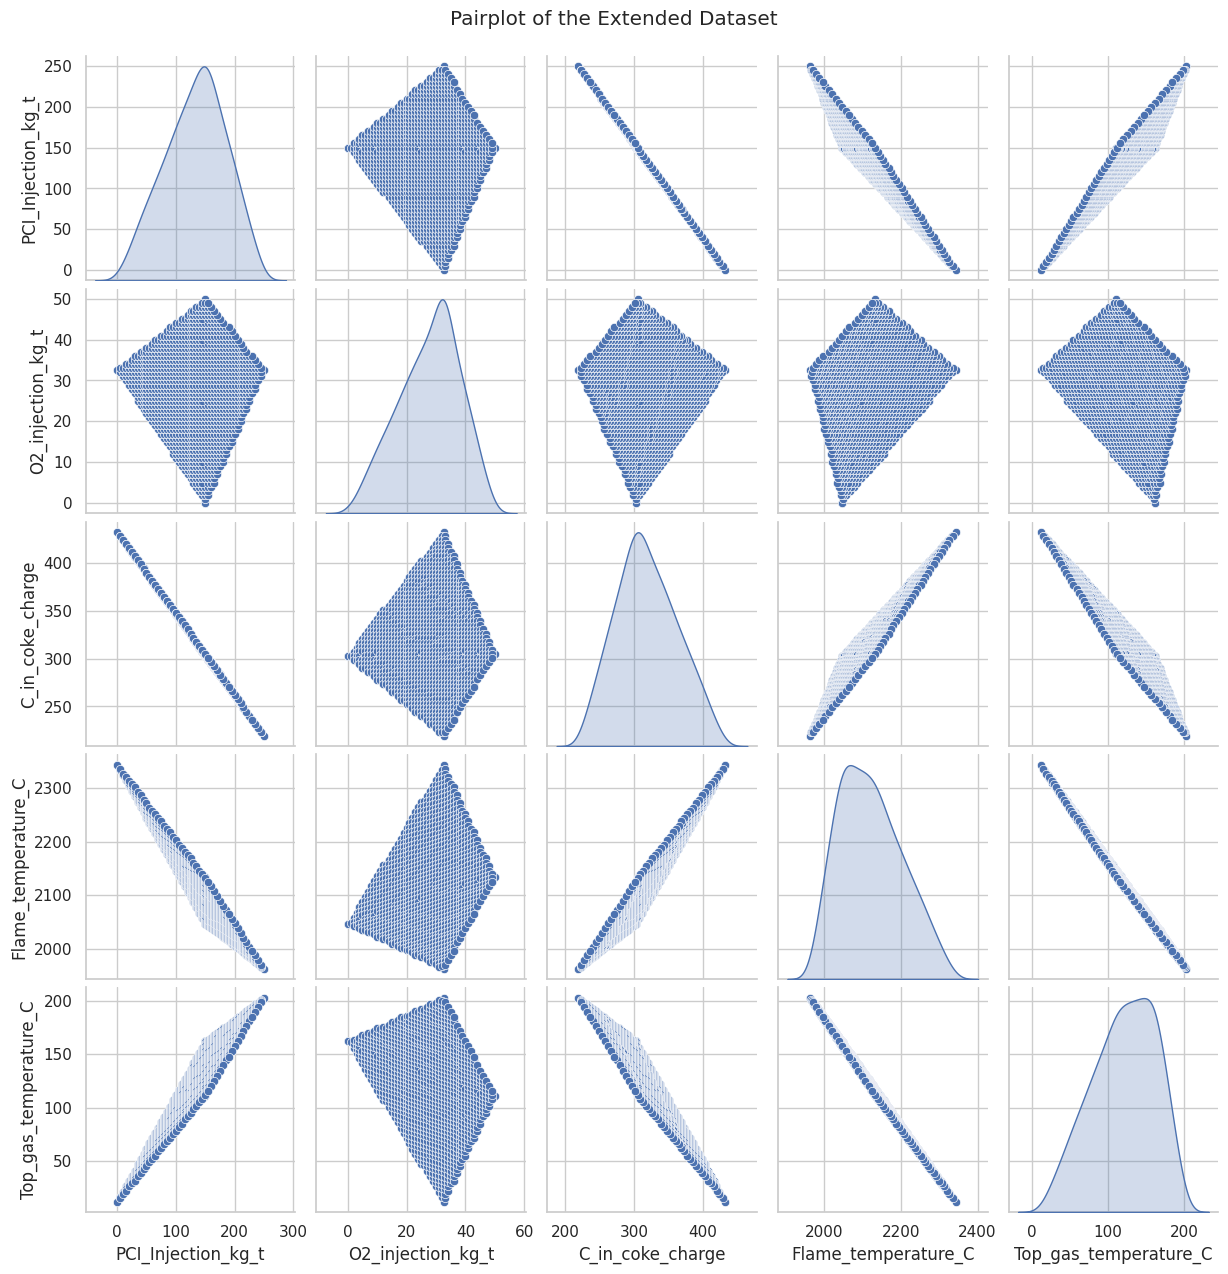

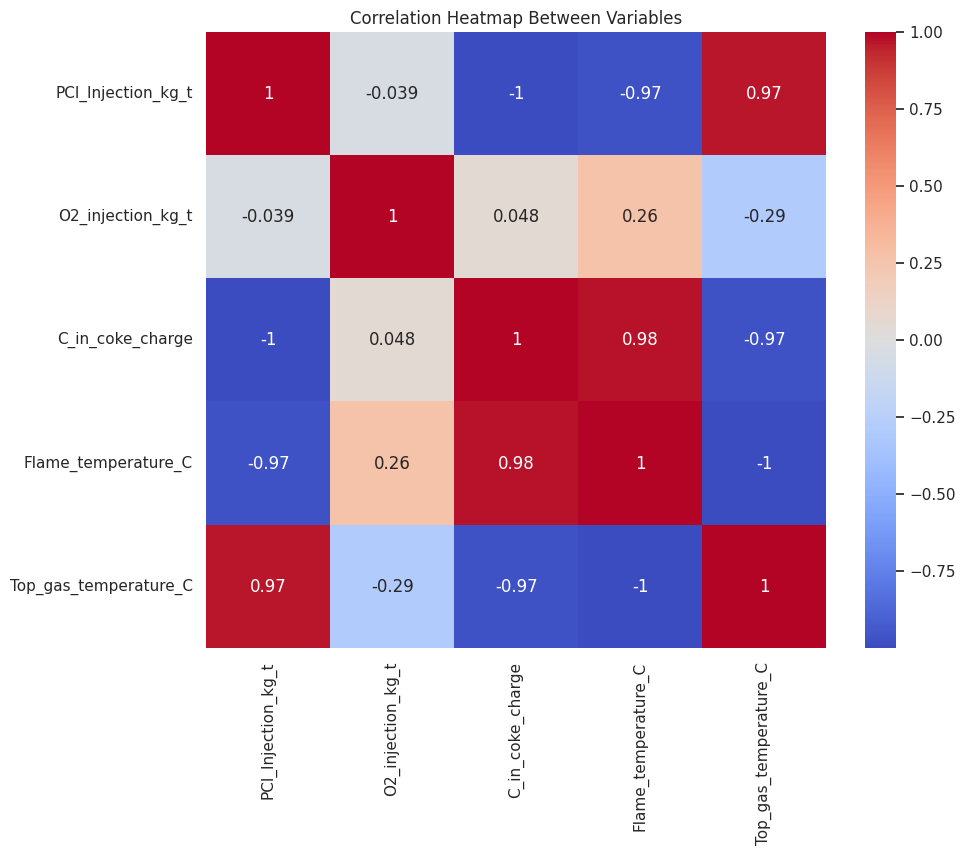

In [9]:
# Pairplot to see the relationship between variables
sns.pairplot(df_extended, diag_kind='kde')
plt.suptitle('Pairplot of the Extended Dataset', y=1.02)
plt.show()

# Heatmap to see correlation
plt.figure(figsize=(10,8))
sns.heatmap(df_extended.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap Between Variables')
plt.show()


### **Predictive Model Training and Model Evaluation**

MSE for C-in-coke charge: 0.01


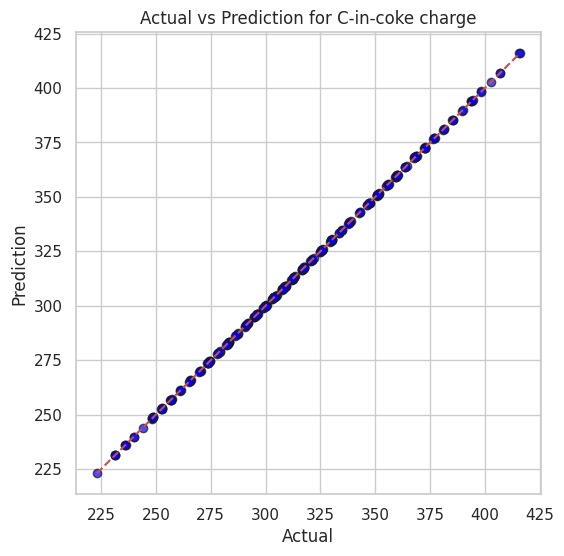

MSE for Flame temperature: 1.81


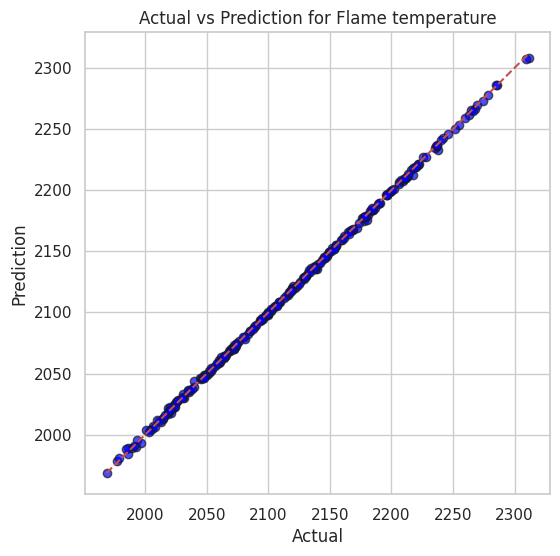

MSE for Top gas temperature: 0.58


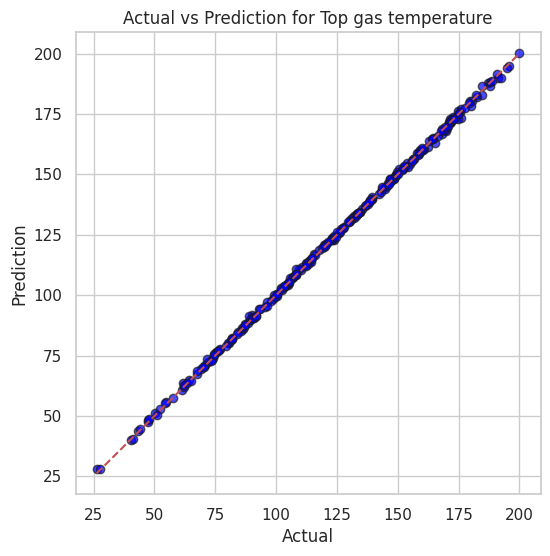

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Separating features and targets
X = df_extended[['PCI_Injection_kg_t', 'O2_injection_kg_t']]
y_coke = df_extended['C_in_coke_charge']
y_flame = df_extended['Flame_temperature_C']
y_topgas = df_extended['Top_gas_temperature_C']

# Splitting data into training and testing
X_train, X_test, y_coke_train, y_coke_test, y_flame_train, y_flame_test, y_topgas_train, y_topgas_test = train_test_split(
    X, y_coke, y_flame, y_topgas, test_size=0.2, random_state=42
)

# Functions for training models
def train_model(y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Train the model for each target
model_coke = train_model(y_coke_train)
model_flame = train_model(y_flame_train)
model_topgas = train_model(y_topgas_train)

# Evaluating the model
def evaluate_model(model, X_test, y_test, target_name):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f'MSE for {target_name}: {mse:.2f}')
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, predictions, color='blue', edgecolor='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title(f'Actual vs Prediction for {target_name}')
    plt.grid(True)
    plt.show()

evaluate_model(model_coke, X_test, y_coke_test, 'C-in-coke charge')
evaluate_model(model_flame, X_test, y_flame_test, 'Flame temperature')
evaluate_model(model_topgas, X_test, y_topgas_test, 'Top gas temperature')


### **Optimization of Combination of O₂ Injection and PCI**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


Optimization Results:
Optimal PCI Injection (kg/t): 150.00
Optimal O2 Injection (kg/t): 32.60
C-in-coke charge: 304.00
Flame temperature (C): 2102.35
Top gas temperature (C): 128.81


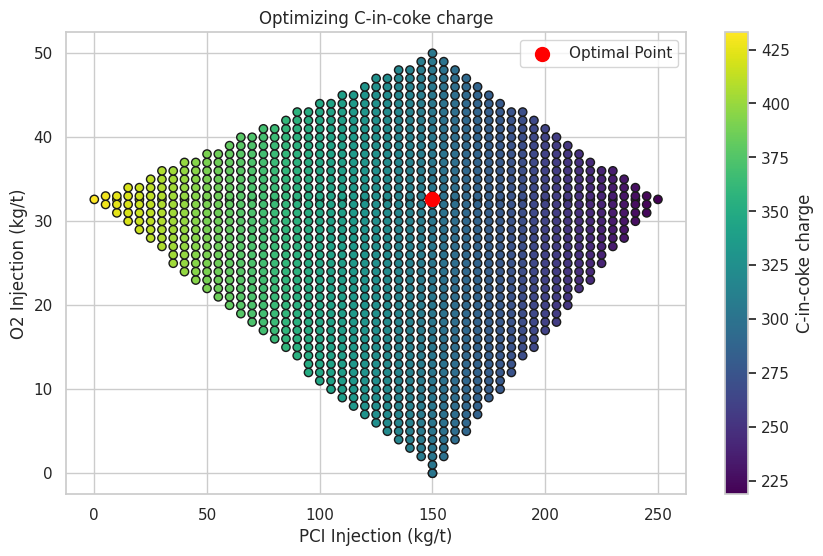

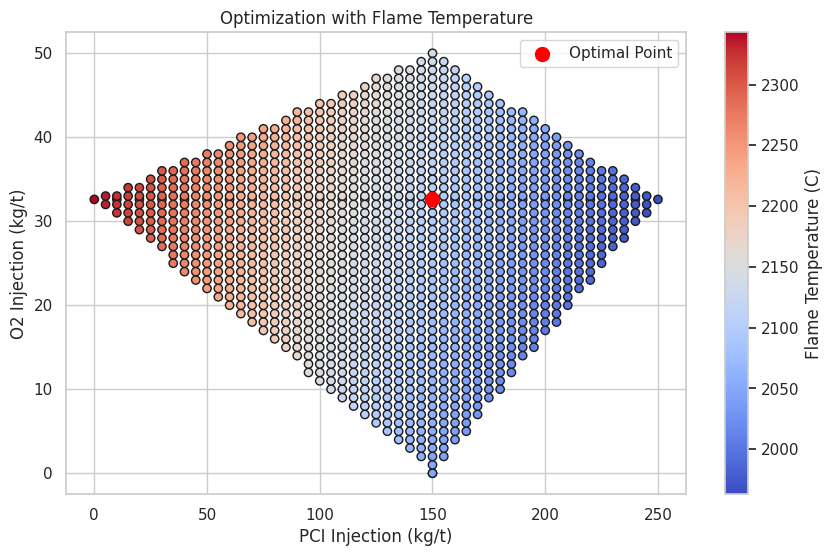

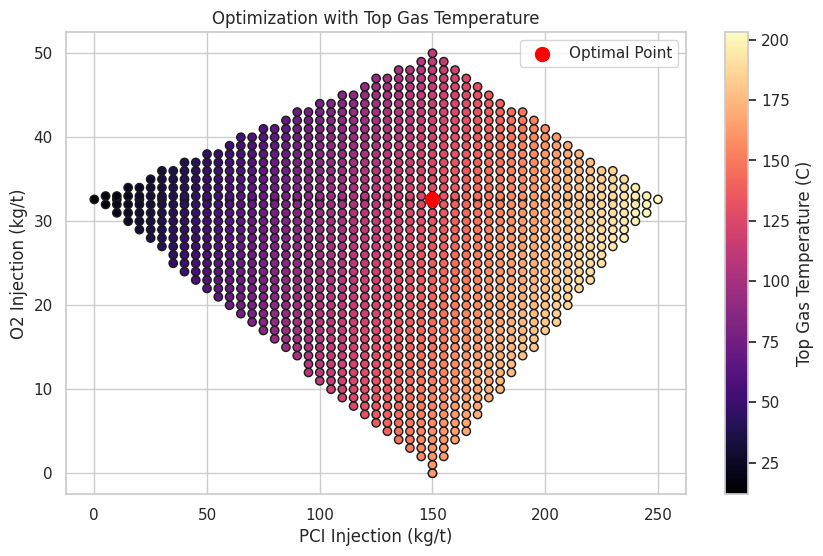

In [11]:
from scipy.optimize import minimize

# Define the objective function and the restriction function.

def objective(vars):
    PCI, O2 = vars
    # Prediction using models
    X_new = np.array([[PCI, O2]])
    c_charge = model_coke.predict(X_new)[0]
    return c_charge

def constraint_topgas_min(vars):
    PCI, O2 = vars
    X_new = np.array([[PCI, O2]])
    topgas = model_topgas.predict(X_new)[0]
    return topgas - 110  # Top gas temp >= 110

def constraint_topgas_max(vars):
    PCI, O2 = vars
    X_new = np.array([[PCI, O2]])
    topgas = model_topgas.predict(X_new)[0]
    return 150 - topgas  # Top gas temp <= 150

def constraint_flame_min(vars):
    PCI, O2 = vars
    X_new = np.array([[PCI, O2]])
    flame = model_flame.predict(X_new)[0]
    return flame - 2100  # Flame temp >= 2100

def constraint_flame_max(vars):
    PCI, O2 = vars
    X_new = np.array([[PCI, O2]])
    flame = model_flame.predict(X_new)[0]
    return 2300 - flame  # Flame temp <= 2300

# Define all constraints
cons = (
    {'type': 'ineq', 'fun': constraint_topgas_min},
    {'type': 'ineq', 'fun': constraint_topgas_max},
    {'type': 'ineq', 'fun': constraint_flame_min},
    {'type': 'ineq', 'fun': constraint_flame_max}
)

# Define PCI and O2 variable limits based on data
bounds = [(0, 250), (0, 50)]

# Initialize the initial values ​​(example: PCI=150, O2=32.6)
initial_guess = [150, 32.6]

# Do optimization
result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)

if result.success:
    optimal_PCI, optimal_O2 = result.x
    optimal_c_charge = model_coke.predict(np.array([[optimal_PCI, optimal_O2]]))[0]
    optimal_flame = model_flame.predict(np.array([[optimal_PCI, optimal_O2]]))[0]
    optimal_topgas = model_topgas.predict(np.array([[optimal_PCI, optimal_O2]]))[0]

    print("\nOptimization Results:")
    print(f'Optimal PCI Injection (kg/t): {optimal_PCI:.2f}')
    print(f'Optimal O2 Injection (kg/t): {optimal_O2:.2f}')
    print(f'C-in-coke charge: {optimal_c_charge:.2f}')
    print(f'Flame temperature (C): {optimal_flame:.2f}')
    print(f'Top gas temperature (C): {optimal_topgas:.2f}')

    # Visualization of optimization results on the C-in-coke charge scatter plot
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df_extended['PCI_Injection_kg_t'], df_extended['O2_injection_kg_t'],
                          c=df_extended['C_in_coke_charge'], cmap='viridis', edgecolor='k')
    plt.scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')
    plt.xlabel('PCI Injection (kg/t)')
    plt.ylabel('O2 Injection (kg/t)')
    plt.title('Optimizing C-in-coke charge')
    plt.legend()
    cbar = plt.colorbar(scatter)
    cbar.set_label('C-in-coke charge')
    plt.show()

    # Visualization on the Flame Temperature surface
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df_extended['PCI_Injection_kg_t'], df_extended['O2_injection_kg_t'],
                          c=df_extended['Flame_temperature_C'], cmap='coolwarm', edgecolor='k')
    plt.scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')
    plt.xlabel('PCI Injection (kg/t)')
    plt.ylabel('O2 Injection (kg/t)')
    plt.title('Optimization with Flame Temperature')
    plt.legend()
    cbar = plt.colorbar(scatter)
    cbar.set_label('Flame Temperature (C)')
    plt.show()

    # Visualization on the surface of Top Gas Temperature
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df_extended['PCI_Injection_kg_t'], df_extended['O2_injection_kg_t'],
                          c=df_extended['Top_gas_temperature_C'], cmap='magma', edgecolor='k')
    plt.scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')
    plt.xlabel('PCI Injection (kg/t)')
    plt.ylabel('O2 Injection (kg/t)')
    plt.title('Optimization with Top Gas Temperature')
    plt.legend()
    cbar = plt.colorbar(scatter)
    cbar.set_label('Top Gas Temperature (C)')
    plt.show()

else:
    print('Optimization failed:', result.message)


### **Visualization of Optimization Results**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


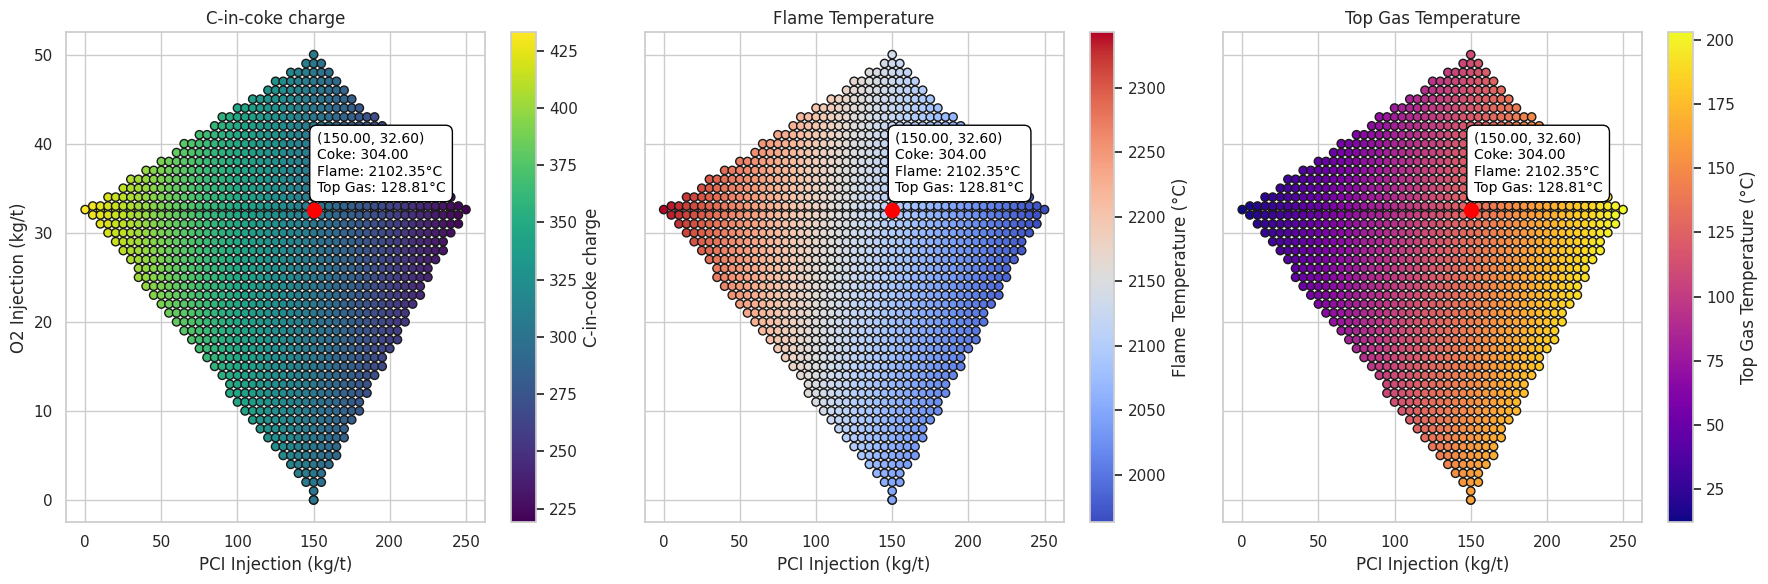

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot for C-in-coke charge
scatter1 = axs[0].scatter(df_extended['PCI_Injection_kg_t'], df_extended['O2_injection_kg_t'],
                          c=df_extended['C_in_coke_charge'], cmap='viridis', edgecolor='k')
axs[0].scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')
axs[0].set_title('C-in-coke charge')
axs[0].set_xlabel('PCI Injection (kg/t)')
axs[0].set_ylabel('O2 Injection (kg/t)')
cbar1 = plt.colorbar(scatter1, ax=axs[0])
cbar1.set_label('C-in-coke charge')

# Plot for Flame Temperature
scatter2 = axs[1].scatter(df_extended['PCI_Injection_kg_t'], df_extended['O2_injection_kg_t'],
                          c=df_extended['Flame_temperature_C'], cmap='coolwarm', edgecolor='k')
axs[1].scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')
axs[1].set_title('Flame Temperature')
axs[1].set_xlabel('PCI Injection (kg/t)')
cbar2 = plt.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Flame Temperature (°C)')

# Plot for Top Gas Temperature
scatter3 = axs[2].scatter(df_extended['PCI_Injection_kg_t'], df_extended['O2_injection_kg_t'],
                          c=df_extended['Top_gas_temperature_C'], cmap='plasma', edgecolor='k')
axs[2].scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')
axs[2].set_title('Top Gas Temperature')
axs[2].set_xlabel('PCI Injection (kg/t)')
cbar3 = plt.colorbar(scatter3, ax=axs[2])
cbar3.set_label('Top Gas Temperature (°C)')

# Optimal Point Label in all subplots
optimal_coke_charge = model_coke.predict([[optimal_PCI, optimal_O2]])[0]
optimal_flame_temp = model_flame.predict([[optimal_PCI, optimal_O2]])[0]
optimal_topgas_temp = model_topgas.predict([[optimal_PCI, optimal_O2]])[0]

# Add text at optimal points in all subplots
for ax in axs:
    ax.text(optimal_PCI + 2, optimal_O2 + 2,
            f'({optimal_PCI:.2f}, {optimal_O2:.2f})\nCoke: {optimal_coke_charge:.2f}\n'
            f'Flame: {optimal_flame_temp:.2f}°C\nTop Gas: {optimal_topgas_temp:.2f}°C',
            color='black', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Setting the layout
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


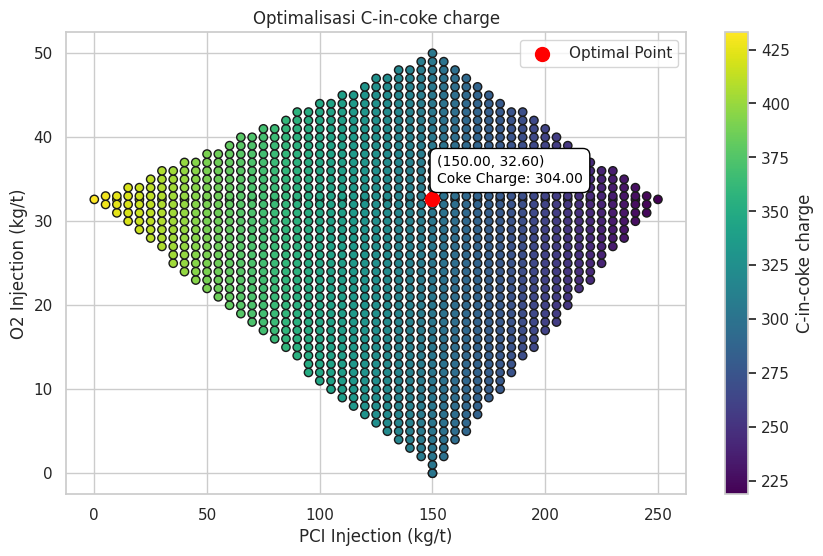

In [13]:
plt.figure(figsize=(10, 6))

# Scatter plot for all data
scatter = plt.scatter(df_extended['PCI_Injection_kg_t'],
                      df_extended['O2_injection_kg_t'],
                      c=df_extended['C_in_coke_charge'],
                      cmap='viridis',
                      edgecolor='k')

# Optimal point
plt.scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')

# Calculating the C-in-coke charge value at the optimum point
optimal_coke_charge = model_coke.predict([[optimal_PCI, optimal_O2]])[0]

# Adding labels at optimal points with background boxes
plt.text(optimal_PCI + 2, optimal_O2 + 2,
         f'({optimal_PCI:.2f}, {optimal_O2:.2f})\nCoke Charge: {optimal_coke_charge:.2f}',
         color='black', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Labels and other graphic elements
plt.xlabel('PCI Injection (kg/t)')
plt.ylabel('O2 Injection (kg/t)')
plt.title('Optimizing C-in-coke charge')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('C-in-coke charge')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


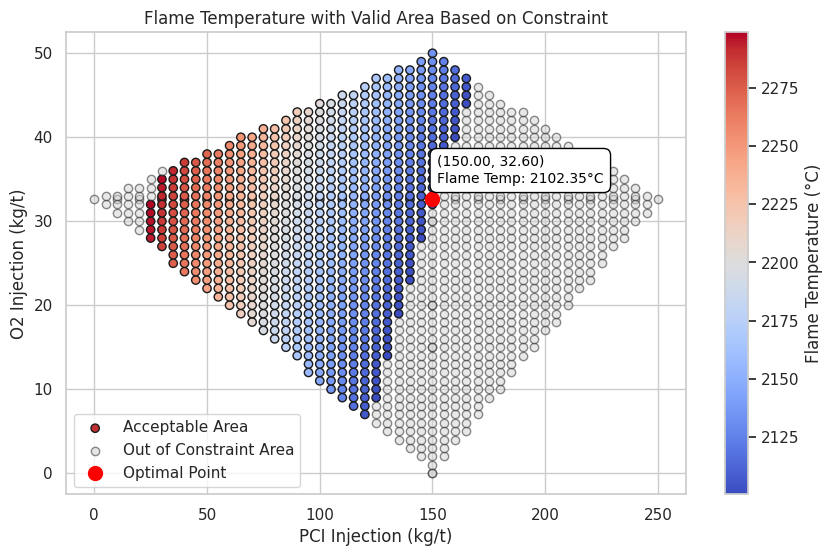

In [14]:
plt.figure(figsize=(10, 6))

# Filter data based on constraints
valid_flame = (df_extended['Flame_temperature_C'] >= 2100) & (df_extended['Flame_temperature_C'] <= 2300)

# Scatter plot with color only for valid data
scatter = plt.scatter(df_extended.loc[valid_flame, 'PCI_Injection_kg_t'],
                      df_extended.loc[valid_flame, 'O2_injection_kg_t'],
                      c=df_extended.loc[valid_flame, 'Flame_temperature_C'],
                      cmap='coolwarm', edgecolor='k', label='Acceptable Area')

# Scatter plot for invalid data in grey
plt.scatter(df_extended.loc[~valid_flame, 'PCI_Injection_kg_t'],
            df_extended.loc[~valid_flame, 'O2_injection_kg_t'],
            color='lightgray', edgecolor='k', alpha=0.5, label='Out of Constraint Area')

# Scatter plot for non-v data Calculating flame temperature values ​​at optimal points
# Assume you have a model to predict flame temperaturealid with gray color
optimal_flame_temp = model_flame.predict([[optimal_PCI, optimal_O2]])[0]

# Optimal point
plt.scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')

# Adding labels at optimal points with background boxes
plt.text(optimal_PCI + 2, optimal_O2 + 2,
         f'({optimal_PCI:.2f}, {optimal_O2:.2f})\nFlame Temp: {optimal_flame_temp:.2f}°C',
         color='black', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel('PCI Injection (kg/t)')
plt.ylabel('O2 Injection (kg/t)')
plt.title('Flame Temperature with Acceptable Area Based on Constraint')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Flame Temperature (°C)')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


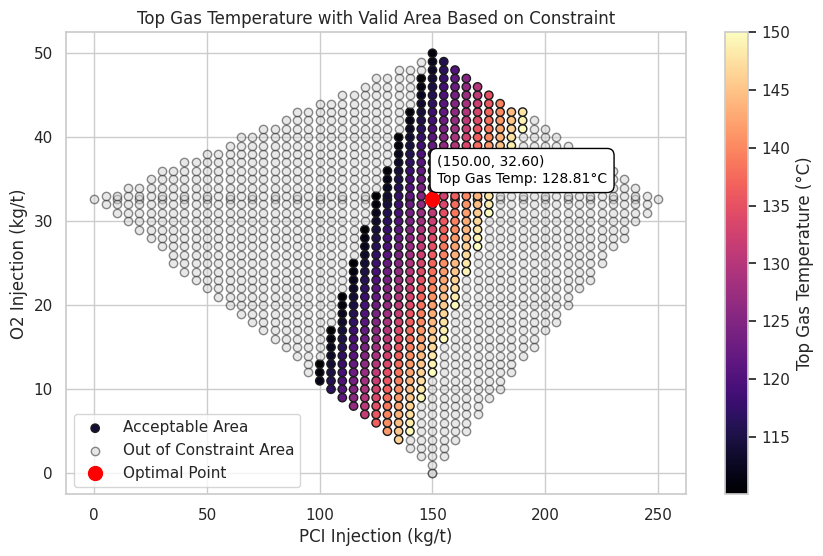

In [15]:
plt.figure(figsize=(10, 6))

# Filter data based on constraints
valid_topgas = (df_extended['Top_gas_temperature_C'] >= 110) & (df_extended['Top_gas_temperature_C'] <= 150)

# Scatter plot with color only for valid data
scatter = plt.scatter(df_extended.loc[valid_topgas, 'PCI_Injection_kg_t'],
                      df_extended.loc[valid_topgas, 'O2_injection_kg_t'],
                      c=df_extended.loc[valid_topgas, 'Top_gas_temperature_C'],
                      cmap='magma', edgecolor='k', label='Acceptable Area')

# Scatter plot for invalid data in grey
plt.scatter(df_extended.loc[~valid_topgas, 'PCI_Injection_kg_t'],
            df_extended.loc[~valid_topgas, 'O2_injection_kg_t'],
            color='lightgray', edgecolor='k', alpha=0.5, label='Out of Constraint Area')

# Calculating the top gas temperature value at the optimal point
# Assume you have a model that can predict the top gas temperature
optimal_topgas_temp = model_topgas.predict([[optimal_PCI, optimal_O2]])[0]

# Optimal point
plt.scatter(optimal_PCI, optimal_O2, color='red', s=100, label='Optimal Point')

# Adding labels at optimal points with background boxes
plt.text(optimal_PCI + 2, optimal_O2 + 2,
         f'({optimal_PCI:.2f}, {optimal_O2:.2f})\nTop Gas Temp: {optimal_topgas_temp:.2f}°C',
         color='black', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel('PCI Injection (kg/t)')
plt.ylabel('O2 Injection (kg/t)')
plt.title('Top Gas Temperature with Acceptable Area Based on Constraint')
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Top Gas Temperature (°C)')
plt.show()
